In [75]:
# Decision trees
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from tqdm import tqdm

In [3]:
# Create the dataset

training_data = [['Green', 'Red', 'Green', 'Yellow', 'Yellow', 'Red'], 
                [1, 2, 1, 2, 2, 1], 
                ['Grape', 'Apple', 'Grape', 'Banana', 'Apple', 'Apple']]

training_data = np.array(training_data)
training_data = np.transpose(training_data)
print(training_data)

features = []
features.append('Color')
features.append('Size')
features.append('Fruit')

def is_numeric(val):
    return isinstance(val, int) or isinstance(val, float)

[['Green' '1' 'Grape']
 ['Red' '2' 'Apple']
 ['Green' '1' 'Grape']
 ['Yellow' '2' 'Banana']
 ['Yellow' '2' 'Apple']
 ['Red' '1' 'Apple']]


In [4]:
# Generate the question class
class Question(object):
    
    def __init__(self, feature, value):
        self.feature = feature
        self.value = value
        
    def match(self, example):
        # Matching takes as input the value to be matched.
        # Then checks the value against the value for the feature.
        # If matched return true else false.
        v = example[self.feature]
        if not is_numeric(v):
            try:
                v = int(v)
            except:
                return self.value == v
        return self.value == v
    
    def __repr__(self):
        # This is just a helper method to print
        # the question in a readable format.
        condition = "=="
        if is_numeric(self.value):
            condition = ">="
        return "Is %s %s %s?" % (
            features[self.feature], condition, str(self.value))

In [5]:
a = Question(1, 2)
a.match(training_data[1])

True

In [6]:
def class_counts(rows):
    """Counts the number of each type of example in a dataset."""
    counts = {}  # a dictionary of label -> count.
    for row in rows:
        # in our dataset format, the label is always the last column
        label = row[-1]
        if label not in counts:
            counts[label] = 0
        counts[label] += 1
    return counts

In [7]:
class_counts(training_data)

{'Apple': 3, 'Banana': 1, 'Grape': 2}

In [8]:
def unique_vals(rows, col):
    """Find the unique values for a column in a dataset."""
    return set([row[col] for row in rows])

In [9]:
unique_vals(training_data, 1)

{'1', '2'}

In [10]:
# Create the partitioning function

'''

Partitioning function partitions the rows into true rows and false rows
according to the partition question.

'''

def partition(question, rows):
    # Iterate over all the rows
    true_rows = []
    false_rows = []
    for row in rows:
        if question.match(row):
            true_rows.append(row)
        else:
            false_rows.append(row)
            
    return true_rows, false_rows

In [11]:
true, false = partition(a, training_data)
print('True rows', true)
print('False rows', false)

True rows [array(['Red', '2', 'Apple'], dtype='<U6'), array(['Yellow', '2', 'Banana'], dtype='<U6'), array(['Yellow', '2', 'Apple'], dtype='<U6')]
False rows [array(['Green', '1', 'Grape'], dtype='<U6'), array(['Green', '1', 'Grape'], dtype='<U6'), array(['Red', '1', 'Apple'], dtype='<U6')]


In [12]:
def gini(rows):
    """Calculate the Gini Impurity for a list of rows.

    There are a few different ways to do this, I thought this one was
    the most concise. See:
    https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity
    """
    # Get the counts for the different classes
    counts = class_counts(rows)
    impurity = 1
    # Iterate over the classes
    for lbl in counts:
        # Get the fraction of items represented by the class
        prob_of_lbl = counts[lbl] / float(len(rows))
        # Calculate the probability square
        impurity -= prob_of_lbl**2
    return impurity  

In [13]:
no_mixing = [['Apple'], ['Apple']]
gini(no_mixing)

0.0

In [14]:
# Calculate the information_gain for a particular question
def info_gain(rows, question):
    # Calculate the impurity for the initial rows
    init_impurity = gini(rows)
    # Partition the rows into true, false according to the question
    true_rows, false_rows = partition(question, rows)
    # Calculate the impuroity of the child nodes
    true_impurity = gini(true_rows)
    false_impurity = gini(false_rows)
    # Calculate the weighted average
    p = len(true_rows)/len(rows)
    we_avg = p*true_impurity + (1-p)*false_impurity
    information_gain = init_impurity - we_avg
    return information_gain

In [15]:
# Demo:
# Calculate the uncertainy of our training data.
current_uncertainty = gini(training_data)
current_uncertainty

0.611111111111111

In [16]:
# How much information do we gain by partioning on 'Green'?
q = Question(0, 'Red')
info_gain(training_data, q)

0.1944444444444443

In [17]:
# Finding the best split/question according to the information gain
def find_best_split(rows):
    # Iterate over the possible questions and features
    best_question = None
    best_ig = 0
    for f in [0, 1]:
        for v in unique_vals(rows, f):
            # Generate the question
            q = Question(f, v)
            # Find the information gain for this question
            ig = info_gain(rows, q)
            if ig >= best_ig:
                best_ig = ig
                best_question = q
    return best_question, best_ig

In [18]:
find_best_split(training_data)

(Is Color == Green?, 0.36111111111111105)

In [19]:
class Leaf:
    """A Leaf node classifies data.

    This holds a dictionary of class (e.g., "Apple") -> number of times
    it appears in the rows from the training data that reach this leaf.
    """

    def __init__(self, rows):
        self.predictions = class_counts(rows)

In [20]:
class Decision_Node:
    """A Decision Node asks a question.

    This holds a reference to the question, and to the two child nodes.
    """

    def __init__(self,
                 question,
                 true_branch,
                 false_branch):
        self.question = question
        self.true_branch = true_branch
        self.false_branch = false_branch

In [21]:
# Finally we define the build tree function
def build_tree(rows):
    # Find the best question to ask at this node
    question, info_gain = find_best_split(rows)
    
    if info_gain == 0:
        return Leaf(rows)
    
    # Partition the rows according to the question
    true_rows, false_rows = partition(question, rows)
    
    # Recursively build the tree for the true rows and the false rows
    true_branch = build_tree(true_rows)
    false_branch = build_tree(false_rows)
    
    return Decision_Node(question, true_branch, false_branch)

In [22]:
def print_tree(node, spacing=""):
    """World's most elegant tree printing function."""

    # Base case: we've reached a leaf
    if isinstance(node, Leaf):
        print (spacing + "Predict", node.predictions)
        return

    # Print the question at this node
    print (spacing + str(node.question))

    # Call this function recursively on the true branch
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Call this function recursively on the false branch
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")

In [23]:
print_tree(build_tree(training_data))

Is Color == Green?
--> True:
  Predict {'Grape': 2}
--> False:
  Is Color == Yellow?
  --> True:
    Predict {'Banana': 1, 'Apple': 1}
  --> False:
    Predict {'Apple': 2}


## Now we will look at Logistic Regression

In [24]:
# Logistic Regression

# Discriminative method for classification
# Directly estimates the posterior probability
import math

EPS = 1e-12

class LogisticRegression(object):
    
    def __init__(self, x, y, lr=1e-2, ep=500):
        self.x = x
        self.y = y
        self._initialize_parameters(x)
        self.num_classes = 3
        self.learning_rate = lr
        self.num_epochs = ep
        self.num_samples = x.shape[0]
        
    def loss_binary_grad(self, y_true, y_pred):
        return -np.sum(np.dot(x.T, (y_true-y_pred)))
    
    def loss_cross_grad(self, y_true, y_pred):
        scores = y_pred.copy()
        scores[np.arange(self.num_samples), y_true]-=1
        scores = scores/self.num_samples
        grad_w = self.x.T.dot(scores)
        grad_b = np.sum(scores, axis=0, keepdims=True)
        return grad_w, grad_b
    
    def _initialize_parameters(self, x):
        n_features = np.shape(x)[1]
        # Initialize parameters between [-1/sqrt(N), 1/sqrt(N)]
        limit = 1 / math.sqrt(n_features)
        self.w = np.random.uniform(-limit, limit, (n_features, 3))
        self.b = np.zeros((1, 3))
    
    def __add_intercept(self, X):
        intercept = np.ones((X.shape[0], 1))
        return np.concatenate((intercept, X), axis=1)
        
    def sgd(self, y_true, y_pred, reg=0.0):
        # Use stochastic gradient descent to calculate the weights
        grad_w, grad_b = self.loss_cross_grad(y_true, y_pred)
        # Add gradient regularization 
        print(grad_w.shape)
        self.w -= self.learning_rate*grad_w
        self.b -=self.learning_rate*grad_b

    def sigmoid(self, x):
        # For 2 class classification
        return 1/(1+np.exp(-x)+EPS)
    
    def softmax(self, x):
        # For numerical stability, subtract the max from x
        e_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return e_x / np.sum(e_x, axis=1, keepdims=True)
    
    def get_w_shapes(self):
        return self.w.shape
    
    def crossentropy_loss(self, y_pred, y_true):
        log_likelihood = -np.log(y_pred[np.arange(self.num_samples), y_true])
        loss = np.sum(log_likelihood) / self.num_samples
        return loss

    def forward(self):
        f_x = np.dot(self.x, self.w) + self.b
        output = self.softmax(f_x)
        return output
    
    def train(self):
        for e in range(self.num_epochs):
            y_pred = self.forward()
            loss = self.crossentropy_loss(y_pred, y)
            # Optimize
            self.sgd(y, y_pred)
            print(loss)
        print('Training complete')
        
    def predict(self, X):
        y_pred = np.dot(X, self.w)+self.b
        y_pred=np.argmax(y_pred, axis=1)
        return y_pred

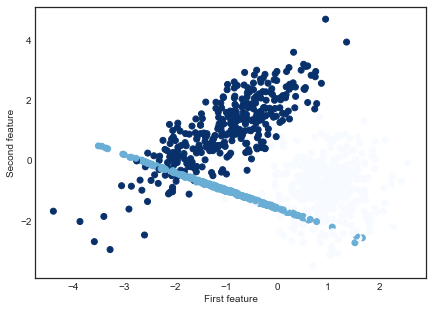

In [53]:
# Import useful libraries
from sklearn.datasets import make_classification 
import matplotlib.pyplot as plt
import numpy as np

# Show plots inline
%matplotlib inline 
plt.rcParams['figure.figsize'] = (7,5)

# Generate toy dataset for classification
# X is a matrix of n_samples x n_features and represents the input features
# y is a vector with length n_samples and represents our target 
X, y = make_classification(n_samples=1000, n_features=2, n_redundant=0, 
                           random_state=2016, n_clusters_per_class=1,
                           n_classes=3)

# Visualize generated dataset
plt.style.use('seaborn-white') # change default style of plot
plt.scatter(X[:,0], X[:,1], c=y, cmap=plt.cm.Blues)
plt.xlabel('First feature')
plt.ylabel('Second feature')
plt.show()

In [26]:
# Split dataset into training and validation
X_train, y_train = X[0:800], y[0:800]
X_val, y_val = X[800:], y[800:]

print(X.shape)
print(y.shape)

lr = LogisticRegression(X ,y)
lr.train()
np.mean(lr.predict(X[:800])==y[:800])

(1000, 2)
(1000,)
(2, 3)
1.3169726358239224
(2, 3)
1.308578608497105
(2, 3)
1.3002550168551397
(2, 3)
1.2920017409339632
(2, 3)
1.2838186531466944
(2, 3)
1.2757056181739508
(2, 3)
1.2676624928624702
(2, 3)
1.2596891261323289
(2, 3)
1.2517853588929972
(2, 3)
1.2439510239684857
(2, 3)
1.2361859460317874
(2, 3)
1.2284899415488126
(2, 3)
1.2208628187319863
(2, 3)
1.2133043775036545
(2, 3)
1.2058144094694134
(2, 3)
1.1983926979014723
(2, 3)
1.1910390177320977
(2, 3)
1.1837531355572086
(2, 3)
1.1765348096501134
(2, 3)
1.1693837899854038
(2, 3)
1.1622998182729551
(2, 3)
1.1552826280019777
(2, 3)
1.14833194449503
(2, 3)
1.1414474849718876
(2, 3)
1.1346289586231186
(2, 3)
1.1278760666932168
(2, 3)
1.1211885025730965
(2, 3)
1.114565951901746
(2, 3)
1.1080080926768088
(2, 3)
1.1015145953738392
(2, 3)
1.0950851230739622
(2, 3)
1.088719331599646
(2, 3)
1.0824168696582819
(2, 3)
1.0761773789932447
(2, 3)
1.0700004945420962
(2, 3)
1.0638858446015784
(2, 3)
1.057833050999032
(2, 3)
1.0518417292698645


(2, 3)
0.4566078222351041
(2, 3)
0.4563088650396096
(2, 3)
0.4560110942265816
(2, 3)
0.4557145022220306
(2, 3)
0.45541908151935434
(2, 3)
0.455124824678589
(2, 3)
0.45483172432567087
(2, 3)
0.45453977315170685
(2, 3)
0.4542489639122547
(2, 3)
0.4539592894266128
(2, 3)
0.4536707425771179
(2, 3)
0.4533833163084537
(2, 3)
0.45309700362696603
(2, 3)
0.45281179759998885
(2, 3)
0.4525276913551771
(2, 3)
0.4522446780798497
(2, 3)
0.45196275102033906
(2, 3)
0.45168190348135057
(2, 3)
0.451402128825329
(2, 3)
0.4511234204718334
(2, 3)
0.45084577189691993
(2, 3)
0.45056917663253243
(2, 3)
0.45029362826590025
(2, 3)
0.4500191204389444
(2, 3)
0.4497456468476903
(2, 3)
0.4494732012416889
(2, 3)
0.449201777423444
(2, 3)
0.44893136924784754
(2, 3)
0.4486619706216211
(2, 3)
0.44839357550276554
(2, 3)
0.4481261779000164
(2, 3)
0.4478597718723063
(2, 3)
0.4475943515282346
(2, 3)
0.4473299110255431
(2, 3)
0.447066444570598
(2, 3)
0.44680394641787907
(2, 3)
0.4465424108694742
(2, 3)
0.44628183227458085
(2

0.88375

In [69]:
# Now we will look at the k means algorithm

# We will be using the LLoyds algorithm for k-means calculation

class KMeans(object):
    
    def __init__(self, x, 
                 num_clusters,
                 num_epochs):
        self.x = x
        self.k = num_clusters
        self.epochs = num_epochs
        
        self.centroids = self.init_centroids()
        
        # Initialize the cluster indicators
        self.cluster_indicators = np.zeros((self.x.shape[0], self.k))
        
    def init_centroids(self):
        centroids = [np.random.normal(loc=0., scale=1., size=self.x.shape[1]) for _ in range(self.k)]
        return centroids 
    
    
    def calculate_distance_to_centroid(self):
        distances = []
        for dp in self.x:
            d_centroids = []
            for mu in self.centroids:
                d_centroids.append(np.sqrt(np.sum((dp-mu)**2)))
            distances.append(d_centroids)
        return distances
    
    def update_cluster_indicators(self):
        # Create the data point-cluster centroid distance matrix
        distance_matrix = self.calculate_distance_to_centroid()
        # Find the cluster with the least distance to the point
        for i, x_point in enumerate(self.x):
            cluster_id = np.argmin(distance_matrix[i])
            # Make changes in the cluster id matrix
            cluster_id_vector = np.zeros(self.k,)
            cluster_id_vector[cluster_id] = 1
            self.cluster_indicators[i] = cluster_id_vector
        return self.cluster_indicators, distance_matrix

    def update_centroids(self):
        new_centroids = []
        for k in range(self.k):
            n_k = 0
            cluster_sum = 0
            for r in range(self.x.shape[0]):
                n_k += self.cluster_indicators[r, k]
            for r in range(self.x.shape[0]):
                cluster_sum += self.cluster_indicators[r, k]*self.x[r]
            assert n_k != 0
            new_centroid = cluster_sum/n_k
            new_centroids.append(new_centroid)
        self.centroids = new_centroids
        
    def fit(self):
        for e in range(self.epochs):
            c_i, _ = self.update_cluster_indicators()
            self.update_centroids()

In [70]:
k = KMeans(x=X, num_clusters=3, num_epochs=100)
k.fit()
Y_pred = k.cluster_indicators

In [71]:
np.mean(Y_pred.argmax(axis=1)==y)

0.438

In [72]:
# Now we will look at gaussian mixture models, also used for Clustering (Supports soft assignment of data points as compared to K-means)

# GMM - Gaussian Mixture Models

# Expectation Maximization

# Variational Inference


In [96]:
class GMM(object):
    
    '''
    Uses the expectation-maximization to compute the optimal parameters.
    
    This is done because calculating the optimal params using max likelihood directly is not 
    possible due to the presenece of a sum inside the log term.
    '''
    
    def __init__(self, 
                 data_points,
                 num_epochs=25,
                 num_clusters=5,):
        
        self.x = data_points
        self.k = num_clusters
        # Initialize the mus and sigmas
        self.initialize_parameters()
        self.gamma = np.zeros((self.x.shape[0], self.k, self.x.shape[1]))
        self.num_epochs = num_epochs
        
    def expectation_method(self, i, k):
        self.x_d = np.random.normal(loc=self.mus[k], scale=self.sigmas[k])
        self.gamma[i, k] = np.dot(self.pi[k], self.x_d)
        denom = 1e-13
        for j in range(self.k):
            self.x_k = np.random.normal(loc=self.mus[j], scale=self.sigmas[j])
            denom += self.pi[j]*self.x_k
        self.gamma[i,k] = self.gamma[i,k]/denom
        return self.gamma
    
    def initialize_parameters(self):
        num_features = self.x.shape[1]
        limit = 1/math.sqrt(num_features)
        self.pi = np.random.uniform(0, limit, (self.k))
        self.mus = np.zeros((self.k, self.x.shape[1]))
        self.sigmas = np.zeros((self.k, self.x.shape[1]))
    
    def maximization_method(self, k):
        # Restimate the parameters using the current gamma
        new_mu = 0
        for i in range(self.x.shape[0]):
            new_mu += self.gamma[i, k]*self.x[i]
        new_mu = new_mu/self.k
        self.mus[k] = new_mu
        new_sigma = 0
        for i in range(self.x.shape[0]):
            new_sigma += self.gamma[i, k]*(np.dot((self.x[i]-self.mus[k]).T, (self.x[i]-self.mus[k])))
        new_sigma = new_sigma/self.k
        self.sigmas[k] = new_sigma
        
        self.pi[k] = self.k/self.x.shape[0]
        
    def fit(self):
        for epoch in tqdm(range(self.num_epochs)):
            # Iterate over the dataset
            for i in range(self.x.shape[0]):
                # Evaluate responsibility for current theta
                for k in range(self.k):
                    self.expectation_method(i,k)
            # Re-estimate the parameters using the current estimates of gamma
            for k in range(self.k):
                self.maximization_method(k)
                
        print('Training Complete')

In [97]:
gmm = GMM(X)
gmm.fit()

100%|██████████| 25/25 [00:10<00:00,  2.38it/s]

Training Complete


In [109]:
# Now we will look into Principal Component analysis or PCA

# First step is to calculate the means of each column
# Next, center the values of each column by subtracting the mean
# Next, calculate the covariance matrix of the previously obtained centered matrix
# Finally, calculate the eignedecomposition of the matrix to get the eigenvectors and eigenvalues
# Select k eigenvectors, also called Principal Components, that have the k largest eigenvalues
# Project the data into subspace by matrix multiplication.

class PCA(object):
    
    def __init__(self, x):
        self.x = x
        self.mean = np.zeros(self.x.shape[1])
        
    def center_data(self):
        mean = np.mean(self.x)
        self.x = self.x-mean
        return self.x
        
    def fit(self, k=40):
        # Center the data
        self.x = self.center_data()
        # Calculate the covariance
        covariance = np.cov(self.x)
        # Calculate the eignedecomposition
        eigenvalues, eigenvectors = np.linalg.eig(covariance)
        # Project the x to the subspace
        P = eigenvectors.T.dot(self.x)
        print(eigenvectors.shape)
        print(P.shape)
        print(X.shape)
        args = np.argsort(eigenvalues)        

In [110]:
pca = PCA(X)
pca.fit()

(1000, 1000)
(1000, 2)
(1000, 2)


In [133]:
# Now we will discuss Linear Regression. 

# Supervised Regression Task

class LinearRegression(object):
    
    def __init__(self, x, y, use_sgd=False, learning_rate=0.01):
        self.x = x
        self.y = y
        self.num_samples = self.x.shape[0]
        self.num_features = self.x.shape[1]
        self.lr = learning_rate
        self.w = None
        if use_sgd:
            self.initialize_weights()
        
    def initialize_weights(self):
        limit = 1/self.num_features
        self.w = np.random.uniform(-limit, limit, (self.num_features))
        
    def forward(self):
        assert self.w is not None
        y_pred = self.w.T.dot(self.x)
        return y_pred
    
    def loss_grad(self):
        loss_grad = np.dot((self.x.T.dot(self.w)), self.x)
        loss_grad = loss_grad - self.x.T.dot(self.y)
        loss_grad = loss_grad/self.num_samples
        return loss_grad
    
    def fit_sgd(self):
        loss_grad = self.loss_grad
        self.w = self.w - self.lr*loss_grad
        return self.w
        
    def fit(self):
        # Calculate the pseudo inverse of x
        # First, calculate the svd of x
        u, sigma, v = np.linalg.svd(self.x)
        # Calculate the pseduoinverse of sigma
        d = np.diag(sigma)
        d = np.linalg.pinv(d)
        print(d.shape)
        print(u.shape)
        print(v.shape)
        pseudo_inverse_svd = np.linalg.pinv(self.x)
        self.w = np.dot(pseudo_inverse_svd, self.y)
        return self.w

[[0.05 0.12]
 [0.18 0.22]
 [0.31 0.35]
 [0.42 0.38]
 [0.5  0.49]]


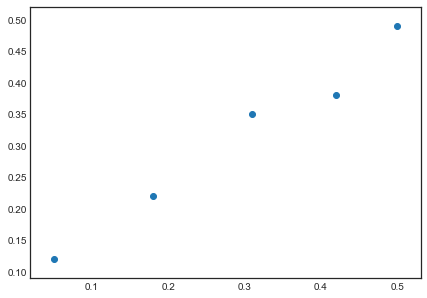

In [127]:
from matplotlib import pyplot
data = np.array([
	[0.05, 0.12],
	[0.18, 0.22],
	[0.31, 0.35],
	[0.42, 0.38],
	[0.5, 0.49],
	])
print(data)
X, y = data[:,0], data[:,1]
X = X.reshape((len(X), 1))

# plot dataset
pyplot.scatter(X, y)
pyplot.show()

In [128]:
lr = LinearRegression(X, y)
print(X.shape)
print(y.shape)
lr.fit()

(5, 1)
(5,)
(1, 1)
(5, 5)
(1, 1)


array([1.00233226])

In [132]:
from collections import defaultdict
# Now we will learn how to implement naieve bayes classifier.
class NaiveBayesClassifier(object):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def separate_data_by_class(self):
        # Get all the classes
        classes = set(self.y)
        separated = defaultdict(list)
        # Iterate through the dataset
        for i in range(self.x.shape[0]):
            separated[y[i]].append(x[i])
        return separated, classses
    
    # Summarize the dataset
    def summarize(self, dataset):
        '''
        The zip function groups the values for each attribute across our data instances into their own lists so that 
        we can compute the mean and standard deviation values for the attribute.
        '''
        summaries = [(np.mean(attributes), np.std(attributes)) for attributes in zip(*dataset)]
        return summaries
        
    # Summarize according to the classes
    def summarize_class(self):
        self.separated, classes = self.separate_data_by_class()
        summarize_class = defaultdict(list)
        for cl in classes:
            summarize_class[cl].extend(self.summarize(self.separated[cl]))
        return summarize_class
    
    def fit(self):
        self.summarized_class = self.summarize_class()
        print(self.summarized_class)
        
    def calc_normal_prob(self, x, mean, std):
        exp = np.exp(-((x-mean)**2)/(2*(std**2)))
        prob = exp/(math.sqrt(2*3.14)*std)
        return prob

In [268]:
# Now we will look how to implement the k nearest neighbours
from collections import Counter

def k_nearest_neighbours(data, predict, k=3):
    if len(data)>=k:
        print("Length of data greater than number of votes")
    distances = []
    for group in data:
        for features in data[group]:
            # Find the euclidean distance between the point and the feature
            euclidean_distance = np.linalg.norm(np.array(features)-np.array(predict))
            distances.append([euclidean_distance, group])
    
    # Get the top groups for which the distances are low
    votes = [i[1] for i in sorted(distances)[:k]]
    # Get the most common group
    votes_class = Counter(votes).most_common(1)[0][0]
    return votes_class

In [199]:
# Now we will look into the Multiclass perceptron

class Perceptron:
    
    def __init__(self, num_classes, num_features, num_epochs, learning_rate=1):
        self.nc = num_classes
        self.nf = num_features
        if self.nc ==2:
            self.weight = np.zeros((self.nf, 1))
            self.bias = np.zeros(1)
        self.epochs = num_epochs
        self.learning_rate = learning_rate
        
    def forward(self, x):
        activation = np.dot(x, self.weight) + self.bias
        return activation
    
    def fit(self, x, y):
        for i in range(self.epochs):
            y_pred = self.predict(x)
            self.weight = self.weight + self.learning_rate*np.dot(x.T, (y_pred-y))
            self.bias = self.bias + self.learning_rate*(y_pred-y)
        self.predict(x)
    
    def predict(self, x):
        activation = self.forward(x)
        pred = [1.0 if x[0]>=0.0 else 0.0 for x in activation]
        return pred

In [224]:
# test predictions
dataset = [[2.7810836,2.550537003,-1],
	[1.465489372,2.362125076,-1],
	[3.396561688,4.400293529,-1],
	[1.38807019,1.850220317,-1],
	[3.06407232,3.005305973,-1],
	[7.627531214,2.759262235,1],
	[5.332441248,2.088626775,1],
	[6.922596716,1.77106367,1],
	[8.675418651,-0.242068655,1],
	[7.673756466,3.508563011,1]]

perceptron = Perceptron(2, 2, num_epochs=20)
dataset = np.array(dataset)
perceptron.fit(dataset[:, :2], dataset[:, 2:])

In [259]:
# Now we will look into how we can apply support vector machines to the above example using hinge loss

class SVM:
    
    def __init__(self, 
                num_classes, num_features, 
                num_epochs, learning_rate=1):
        
        self.nc = num_classes
        self.nf = num_features
        self.epochs = num_epochs
        self.lr = learning_rate
        if self.nc==2:
            self.weights = np.random.normal(loc=0., scale=1., size=(self.nf, 1))
        else:
            self.weights = np.random.normal(loc=0., scale=1., size=(self.nf, self.nc))
            
    def predict(self, x):
        o = np.dot(x, self.weights)
        return o

    def fit(self, x, y):
        
        for e in range(1,self.epochs+1):
            # Update the weights
            y_pred = self.predict(x)
            if (y*y_pred)[0]<1:
                self.weights = self.weights + self.lr*(np.dot(x.T, y) - (2*self.weights))
            else:
                self.weights = self.weights - self.lr*(2*self.weights)
                
        out = self.predict(x)
        
        return self.weights, out

In [260]:
svm = SVM(2,2,100000)
svm.fit(dataset[:, :2], dataset[:, 2:])

(array([[0.31938206],
        [0.66131445]]), array([[2.57493519],
        [2.03015846],
        [3.99477857],
        [1.66690215],
        [2.966062  ],
        [4.26083662],
        [3.08432514],
        [3.38218319],
        [2.61068957],
        [4.77112357]]))

In [267]:
nodes = ('A', 'B', 'C', 'D', 'E', 'F', 'G')
distances = {
    'B': {'A': 5, 'D': 1, 'G': 2},
    'A': {'B': 5, 'D': 3, 'E': 12, 'F' :5},
    'D': {'B': 1, 'G': 1, 'E': 1, 'A': 3},
    'G': {'B': 2, 'D': 1, 'C': 2},
    'C': {'G': 2, 'E': 1, 'F': 16},
    'E': {'A': 12, 'D': 1, 'C': 1, 'F': 2},
    'F': {'A': 5, 'E': 2, 'C': 16}}

# Mark all nodes univisted and store them
unvisited = {node: None for node in nodes} #using None as +inf
visited = {}
source = 'B'
current = 'B'
# Set the distance for our initial node as 0 and inf for all other nodes
currentDistance = 0
unvisited[current] = currentDistance

while True:
    # Iterate through all the neighbours of the current node
    for neighbour, distance in distances[current].items():
        # Move forward if the neighbour is already visited
        if neighbour not in unvisited: 
            continue
        # Calculate the distance of the neighbour through the current node    
        newDistance = currentDistance + distance
        # Compare the newly calculated distance to the assigned and the save the smaller one.
        if unvisited[neighbour] is None or unvisited[neighbour] > newDistance:
            unvisited[neighbour] = newDistance
    
    # Mark the current node as visited
    visited[current] = currentDistance
    # Remove the current node from the unvisited
    del unvisited[current]
    # Stop if all nodes are completed
    if not unvisited: break
    # Select the candidates for next iteration if the cost of the univisted neighbours is not None
    candidates = [node for node in unvisited.items() if node[1]]
    # Select the candidates with the smallest distance; It is the current node now
    current, currentDistance = sorted(candidates, key = lambda x: x[1])[0]

print(visited)
print('Source node is ', source)

{'A': 5, 'C': None, 'D': 1, 'E': None, 'F': None, 'G': 2}
{'A': 4, 'C': None, 'E': 2, 'F': None, 'G': 2}
{'A': 4, 'C': 3, 'F': 4, 'G': 2}
{'A': 4, 'C': 3, 'F': 4}
{'A': 4, 'F': 4}
{'F': 4}
{}
{'B': 0, 'D': 1, 'E': 2, 'G': 2, 'C': 3, 'A': 4, 'F': 4}
Source node is  B


In [ ]:
class NaiveBayes():
        
    def fit(self, x, y):
        self.x, self.y = x, y
        # Calculate the mean and variance for each feature for each class
        num_classes = np.unique(self.y)
        # Initialize the set of paramters with an empty list
        self.params = []
        for i, class_ in enumerate(num_classes):
            # Get the features for which the class is class_
            x = self.x[np.where(self.y == class_)]
            self.params.append([])
            # Add the mean and variance of each feature(column)
            for col in x.T:
                parameters = {'mean':np.mean(col), 'var':np.var(col)}
                # Add the feature means and vars to the specific class parameter array
                self.params[i].append(parameters)
                
    def calc_likelihood(self, mean, var, x):
        # Calculate the gaussian likelihood
        eps = 1e-4
        coeff = 1.0 / math.sqrt(2.0 * math.pi * var + eps)
        exponent = math.exp(-(math.pow(x - mean, 2) / (2 * var + eps)))
        return coeff * exponent
    
    
    def calc_prior(self, c):
        class_prior = np.mean(self.y==c)
        return class_prior
    
    # Sample classification logic
    def classify(self, sample):
        # Use bayes rule to calculate the posterior for each class and then get the maximum posterior
        posteriors = []
        num_classes = np.unique(self.y)
        for i, class_ in enumerat(num_classes):
            # Initialize the posterior with the class prior
            posterior = self.calc_prior(class_)
            # Assume naive independence
            # Iterate over the features and params
            for feature_sample, params in zip(sample, self.parameters[i]):
                likelihood = self.calc_likelihood(params['mean'], params['var'], feature_sample)
                posterior = posterior*likelihood
            
            posteriors.append(posterior)
            
        # 
            
            